# Part C: Modeling

## Extend a fine-tuning method

In this part, we use a natural language processing model, BERT, for our project. BERT is a machine learning framework which has been pre-trained using text from Wikipedia and BookCorpus which can provide a fuller understanding of the model's data. BERT can be fine-tuned to tailor various task such as sentiment analysis and named entity recognition.

In [1]:
import torch 
import torch.optim as optim 
import numpy as np 
import pandas as pd
import random 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, get_cosine_with_hard_restarts_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report

def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(0)

## Step 1: Processing the data and combining two datasets

In [2]:
new_df = pd.read_csv('final-data-updated.csv', encoding='utf-8-sig')
new_df = new_df.dropna(subset=['Sentiment'])

dataset = load_dataset('financial_phrasebank', 'sentences_50agree')
train_dataset = dataset['train']

# Extract data from Hugging Face
huggingface_x = train_dataset['sentence']
huggingface_y = train_dataset['label']

# Extract columns from our dataset
new_x = new_df['Summary'].tolist()
new_y = new_df['Sentiment'].tolist()

# Split dataset into train and test sets
x_train, x_valid, y_train, y_valid = train_test_split(huggingface_x, huggingface_y, test_size=0.2, random_state=42)
x_train += new_x
y_train += new_y

print("Trainset:", len(x_train))
print("Validset:", len(x_valid))


Trainset: 6152
Validset: 970


In [3]:
# Convert to Pytorch format
class News(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    def __len__(self):
        return len(self.x)
    
trainset = News(x_train, y_train)
validset = News(x_valid, y_valid)

def collate_fn(batch):   
    # Batch retrieval 
    (x, y) = zip(*batch)
    # Tokenise  x into tesnor (datatype = float)
    x = tokenizer(x, max_length=512, truncation=True, padding="longest", return_tensors='pt')
    # Preparing labels (datatype = int)
    y = {'labels': torch.LongTensor(y)}
    return {**x, **y}

# Initial tokenizer
tokenizer = BertTokenizer.from_pretrained("textattack/bert-base-uncased-yelp-polarity")
# Set up a DataLoader for the training dataset
train_loader = DataLoader(trainset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
# Set up a DataLoader for the testing dataset
valid_loader = DataLoader(validset, batch_size = 16, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

## Step 2: Defining functions for model training

The below code defines functions to train and validate model using PyTorch, specifically tailored for our classification tasks. 

1. **Training function**: This function iterates over training data. For each batch, the code resets model gradients back to zero, performs a forward pass to compute the outputs and loss. Then conducts backpropogatoin, following by an optimisation to update model weights. 

2. **Validation function**:  Similar to the training function, this function iterates over the validation data to evaluate the model's performance without updating model weights.

In [4]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True)
    
    model.train()
    for input_datas in train_pbar:
        for key in input_datas.keys():
            input_datas[key] = input_datas[key].to(device)
        optimizer.zero_grad() # grad -> 0 to prevent gradient from accumulating
        outputs = model(**input_datas) # forward propagation
        
        logits = outputs.logits
        loss = outputs.loss
        
        loss.backward() # backpropogation
        optimizer.step() # update weight
        scheduler.step() # update schedular to adjust learning rate
        
        train_pbar.set_description(f'Train Epoch {epoch}')
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # show current loss
        
        pred = torch.argmax(logits, dim = 1)
        train_acc += sum(pred == input_datas['labels'])
        train_loss += loss.item() # save information of loss
    return train_loss/len(train_loader), train_acc/len(trainset) # loss & accuracy

def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    y_preds, y_trues = [], []
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            for key in input_datas.keys():
                input_datas[key] = input_datas[key].to(device)
            
            outputs = model(**input_datas)
            logits = outputs.logits
            loss = outputs.loss
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = torch.argmax(logits, dim = 1)
            valid_acc += sum(pred == input_datas['labels'])
            valid_loss += loss.item()

            y_trues.extend(input_datas['labels'].cpu())
            y_preds.extend(pred.cpu())

    print(classification_report(y_trues, y_preds))

    return valid_loss/len(valid_loader), valid_acc/len(validset)

# Function for plotting the result of loss   
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('Result')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained("textattack/bert-base-uncased-yelp-polarity", num_labels = 3, ignore_mismatched_sizes=True)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at textattack/bert-base-uncased-yelp-polarity and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## Step 3: Model initialisation -> Training & Validation

This section train and validate a BERT model over 20 epochs to enhance the model's accuracy. It employs a sophisticated learnign rate scheduler also an optimizer, AdamW. It also includes mechinisms for saving the model's best state based on accuracy.

  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 0: 100%|██████████| 61/61 [00:01<00:00, 41.40it/s, loss=0.524]


              precision    recall  f1-score   support

           0       0.45      0.74      0.56       110
           1       0.81      0.85      0.83       571
           2       0.54      0.36      0.43       289

    accuracy                           0.69       970
   macro avg       0.60      0.65      0.61       970
weighted avg       0.69      0.69      0.68       970

Saving Model With Acc 0.68969
Train Loss: 0.90742 Train Acc: 0.56713| Valid Loss: 0.69147 Valid Acc: 0.68969| Best Acc: 0.68969



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 1: 100%|██████████| 61/61 [00:01<00:00, 42.34it/s, loss=0.425]


              precision    recall  f1-score   support

           0       0.63      0.85      0.72       110
           1       0.87      0.87      0.87       571
           2       0.84      0.72      0.77       289

    accuracy                           0.82       970
   macro avg       0.78      0.81      0.79       970
weighted avg       0.83      0.82      0.82       970

Saving Model With Acc 0.82268
Train Loss: 0.55829 Train Acc: 0.78722| Valid Loss: 0.44723 Valid Acc: 0.82268| Best Acc: 0.82268



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 2: 100%|██████████| 61/61 [00:01<00:00, 42.11it/s, loss=0.716]


              precision    recall  f1-score   support

           0       0.72      0.78      0.75       110
           1       0.90      0.86      0.88       571
           2       0.77      0.81      0.79       289

    accuracy                           0.84       970
   macro avg       0.80      0.82      0.81       970
weighted avg       0.84      0.84      0.84       970

Saving Model With Acc 0.83608
Train Loss: 0.29092 Train Acc: 0.90068| Valid Loss: 0.45479 Valid Acc: 0.83608| Best Acc: 0.83608



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 3: 100%|██████████| 61/61 [00:01<00:00, 43.01it/s, loss=0.215]


              precision    recall  f1-score   support

           0       0.72      0.84      0.77       110
           1       0.90      0.85      0.88       571
           2       0.77      0.81      0.79       289

    accuracy                           0.84       970
   macro avg       0.80      0.83      0.81       970
weighted avg       0.84      0.84      0.84       970

Saving Model With Acc 0.83814
Train Loss: 0.13403 Train Acc: 0.95741| Valid Loss: 0.51246 Valid Acc: 0.83814| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 4: 100%|██████████| 61/61 [00:01<00:00, 42.33it/s, loss=0.193]


              precision    recall  f1-score   support

           0       0.60      0.88      0.71       110
           1       0.91      0.81      0.86       571
           2       0.77      0.80      0.79       289

    accuracy                           0.82       970
   macro avg       0.76      0.83      0.79       970
weighted avg       0.83      0.82      0.82       970

Train Loss: 0.08848 Train Acc: 0.97399| Valid Loss: 0.58804 Valid Acc: 0.81546| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 5: 100%|██████████| 61/61 [00:01<00:00, 42.31it/s, loss=1.437]


              precision    recall  f1-score   support

           0       0.76      0.81      0.78       110
           1       0.85      0.92      0.88       571
           2       0.85      0.69      0.76       289

    accuracy                           0.84       970
   macro avg       0.82      0.81      0.81       970
weighted avg       0.84      0.84      0.84       970

Train Loss: 0.15650 Train Acc: 0.94863| Valid Loss: 0.62401 Valid Acc: 0.83814| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 6: 100%|██████████| 61/61 [00:01<00:00, 42.59it/s, loss=0.274]


              precision    recall  f1-score   support

           0       0.73      0.83      0.77       110
           1       0.86      0.89      0.88       571
           2       0.82      0.73      0.77       289

    accuracy                           0.84       970
   macro avg       0.80      0.82      0.81       970
weighted avg       0.84      0.84      0.83       970

Train Loss: 0.08081 Train Acc: 0.97659| Valid Loss: 0.65080 Valid Acc: 0.83505| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 7: 100%|██████████| 61/61 [00:01<00:00, 43.22it/s, loss=1.653]


              precision    recall  f1-score   support

           0       0.71      0.82      0.76       110
           1       0.88      0.87      0.87       571
           2       0.79      0.76      0.78       289

    accuracy                           0.83       970
   macro avg       0.79      0.82      0.80       970
weighted avg       0.83      0.83      0.83       970

Train Loss: 0.03712 Train Acc: 0.98943| Valid Loss: 0.72172 Valid Acc: 0.83196| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 8: 100%|██████████| 61/61 [00:01<00:00, 43.38it/s, loss=0.449]


              precision    recall  f1-score   support

           0       0.71      0.85      0.77       110
           1       0.92      0.81      0.86       571
           2       0.74      0.85      0.79       289

    accuracy                           0.83       970
   macro avg       0.79      0.84      0.81       970
weighted avg       0.84      0.83      0.83       970

Train Loss: 0.04456 Train Acc: 0.98781| Valid Loss: 0.74777 Valid Acc: 0.82887| Best Acc: 0.83814



  0%|          | 0/385 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_29568\682512428.py:16: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = {'labels': torch.LongTensor(y)}
Valid Epoch 9: 100%|██████████| 61/61 [00:01<00:00, 42.96it/s, loss=0.916]


              precision    recall  f1-score   support

           0       0.69      0.84      0.76       110
           1       0.89      0.85      0.87       571
           2       0.79      0.79      0.79       289

    accuracy                           0.83       970
   macro avg       0.79      0.83      0.81       970
weighted avg       0.84      0.83      0.83       970

Train Loss: 0.08992 Train Acc: 0.97285| Valid Loss: 0.64284 Valid Acc: 0.83196| Best Acc: 0.83814



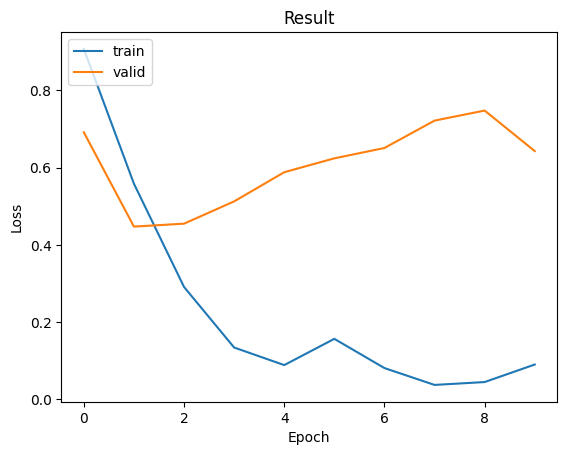

In [5]:
best_acc = 0
loss_record = {'train':[], 'valid':[]}
epochs = 20

num_training_steps = len(train_loader) * epochs
num_warmup_steps = num_training_steps * 0.05
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
# Cosine Annealing with Hard Restarts and Warmup
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps, num_cycles=5)

for epoch in range(10):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # save best weight
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'model.ckpt')
        print(f'Saving Model With Acc {best_acc:.5f}')
    
    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

show_training_loss(loss_record)
